In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (41

## 시작

In [3]:
from datasets import load_dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from transformers import BertTokenizer, BertModel, AdamW, get_scheduler
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm.auto import tqdm

In [4]:
from sklearn.preprocessing import LabelEncoder
import json

path = '/content/drive/MyDrive/데이터/'
df_train = pd.read_csv(path+'LSA_train_df.csv')
df_val = pd.read_csv(path+'LSA_val_df.csv')
df_test = pd.read_csv(path+'LSA_test_df.csv')

with open(path+'오리지널/label_mapping.json', 'r') as f:
    label_mapping = json.load(f)

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(list(label_mapping.keys()))

In [5]:
df_train['topic_distribution'] = df_train['topic_distribution'].apply(lambda x: list(map(float, x.split(','))))
df_val['topic_distribution'] = df_val['topic_distribution'].apply(lambda x: list(map(float, x.split(','))))
df_test['topic_distribution'] = df_test['topic_distribution'].apply(lambda x: list(map(float, x.split(','))))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

class LDA_attended_BERTModel(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(LDA_attended_BERTModel, self).__init__()
        self.bert = bert_model
        self.bert_hidden_size = self.bert.config.hidden_size
        self.topic_size = 10
        self.fc_layers = nn.Sequential(
            nn.Linear(self.bert_hidden_size, 512),
            nn.ReLU(),
        )
        self.final_layer = nn.Sequential(
            nn.Linear(512 + self.topic_size, num_labels),
        )

    def forward(self, input_ids, attention_mask, topic_distribution):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        intermediate_output = self.fc_layers(pooled_output)
        combined_output = torch.cat((intermediate_output, topic_distribution), dim=1)
        logits = self.final_layer(combined_output)
        return logits

In [7]:
class NewsDataset(Dataset):
    def __init__(self, documents, labels, topic_distributions, tokenizer, max_length):
        self.documents = documents
        self.labels = labels
        self.topic_distributions = topic_distributions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        document = self.documents[idx]
        label = self.labels[idx]
        topic_distribution = self.topic_distributions[idx]

        encoding = self.tokenizer(
            document,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        item['topic_distribution'] = torch.tensor(topic_distribution, dtype=torch.float)

        return item

In [8]:
tokenizer = BertTokenizer.from_pretrained('klue/roberta-base')
model = LDA_attended_BERTModel(num_labels=len(label_encoder.classes_), bert_model = BertModel.from_pretrained('klue/roberta-base'))

train_dataset = NewsDataset(df_train['document'].tolist(), df_train['press_encoded'].tolist(), df_train['topic_distribution'].tolist(), tokenizer, max_length=512)
val_dataset = NewsDataset(df_val['document'].tolist(), df_val['press_encoded'].tolist(), df_val['topic_distribution'].tolist(), tokenizer, max_length=512)
test_dataset = NewsDataset(df_test['document'].tolist(), df_test['press_encoded'].tolist(), df_test['topic_distribution'].tolist(), tokenizer, max_length=512)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0

LDA_attended_BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, el

In [9]:
progress_bar = tqdm(range(num_training_steps))

total_steps = 0
ts = []
tl = []
ta = []

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for step, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        topic_distribution = batch['topic_distribution'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, topic_distribution=topic_distribution)

        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

        progress_bar.update(1)

        if (total_steps + 1) % 100 == 0:
            avg_loss = total_loss / (step + 1)
            accuracy = correct_predictions / total_predictions
            print(f"Step {total_steps + 1}/{len(train_dataloader)}")
            ts.append(total_steps)
            print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")
            tl.append(avg_loss)
            ta.append(accuracy)

        total_steps += 1

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions

  0%|          | 0/2517 [00:00<?, ?it/s]

Step 100/839
Train Loss: 1.5915, Train Accuracy: 0.2550
Step 200/839
Train Loss: 1.5867, Train Accuracy: 0.2644
Step 300/839
Train Loss: 1.5677, Train Accuracy: 0.2783
Step 400/839
Train Loss: 1.5455, Train Accuracy: 0.2922
Step 500/839
Train Loss: 1.5263, Train Accuracy: 0.3013
Step 600/839
Train Loss: 1.5041, Train Accuracy: 0.3113
Step 700/839
Train Loss: 1.4848, Train Accuracy: 0.3248
Step 800/839
Train Loss: 1.4673, Train Accuracy: 0.3305
Step 900/839
Train Loss: 1.3352, Train Accuracy: 0.4098
Step 1000/839
Train Loss: 1.2853, Train Accuracy: 0.4488
Step 1100/839
Train Loss: 1.1996, Train Accuracy: 0.4847
Step 1200/839
Train Loss: 1.1433, Train Accuracy: 0.5045
Step 1300/839
Train Loss: 1.1017, Train Accuracy: 0.5174
Step 1400/839
Train Loss: 1.0744, Train Accuracy: 0.5303
Step 1500/839
Train Loss: 1.0473, Train Accuracy: 0.5376
Step 1600/839
Train Loss: 1.0289, Train Accuracy: 0.5432
Step 1700/839
Train Loss: 0.8079, Train Accuracy: 0.6136
Step 1800/839
Train Loss: 0.8548, Train 

In [10]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    progress_bar = tqdm(total=len(dataloader), desc="Evaluating")

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            topic_distribution = batch['topic_distribution'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, topic_distribution=topic_distribution)

            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            probabilities = torch.softmax(logits, dim=-1)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            progress_bar.update(1)

    progress_bar.close()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    roc_auc = roc_auc_score(all_labels, np.array(all_probabilities), multi_class='ovr')

    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return avg_loss, accuracy, f1, precision, recall, roc_auc

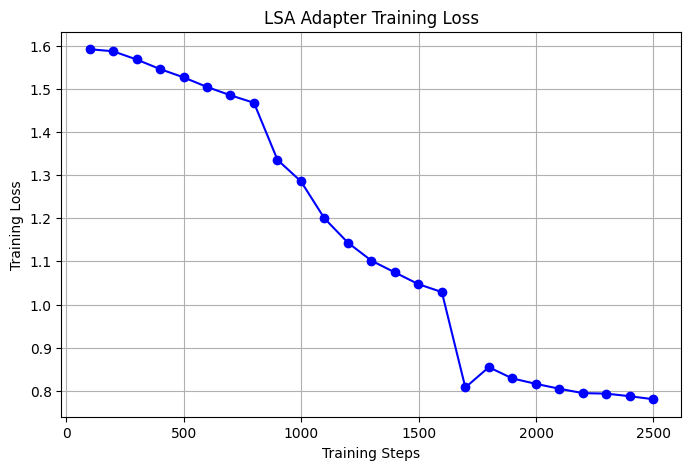

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ts, tl, marker='o', linestyle='-', color='b')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('LSA Adapter Training Loss')
plt.grid(True)
plt.show()

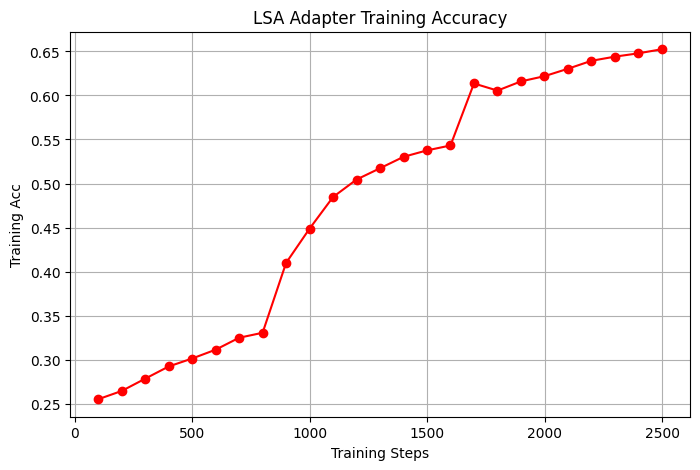

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ts, ta, marker='o', linestyle='-', color='r')
plt.xlabel('Training Steps')
plt.ylabel('Training Acc')
plt.title('LSA Adapter Training Accuracy')
plt.grid(True)
plt.show()

In [13]:
print("Validation metrics:")
evaluate(model, val_dataloader)

Validation metrics:


Evaluating:   0%|          | 0/180 [00:00<?, ?it/s]

Loss: 0.7551
Accuracy: 0.6588
F1 Score: 0.6562
Precision: 0.6605
Recall: 0.6588
ROC AUC: 0.9061


(0.7551018395357662,
 0.658774373259053,
 0.6561829587398446,
 0.6604811616825443,
 0.658774373259053,
 0.9060656424399657)

In [14]:
print("Test metrics:")
evaluate(model, test_dataloader)

Test metrics:


Evaluating:   0%|          | 0/180 [00:00<?, ?it/s]

Loss: 0.8088
Accuracy: 0.6319
F1 Score: 0.6292
Precision: 0.6332
Recall: 0.6319
ROC AUC: 0.8962


(0.808772520803743,
 0.6319444444444444,
 0.6291829217399538,
 0.6331537933739674,
 0.6319444444444444,
 0.8961632336896195)

In [15]:
torch.save(model.state_dict(), 'LSA_Adapter_model.pt')